## Building a CNN model for predicting method of text input (handwritten or printed).

#### Importing necessary libraries

In [102]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

##### Defining constants

In [103]:
batch_size = 6
img_height = 180
img_width = 180

In [104]:
data_dir = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\dataset"

#### Creating training and validation datasets. 
This is best done with use tensorflow utility function that allows immediate split of data into required proportion for training and validation.

In [105]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.35,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.
Using 37 files for training.


In [106]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.35,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.
Using 19 files for validation.


Naturally, there are two class names in the dataset

In [107]:
class_names = train_ds.class_names
print("Clas names:", class_names)

Clas names: ['Handwritten', 'Printed']


Let us take a look at few training images from both classes.

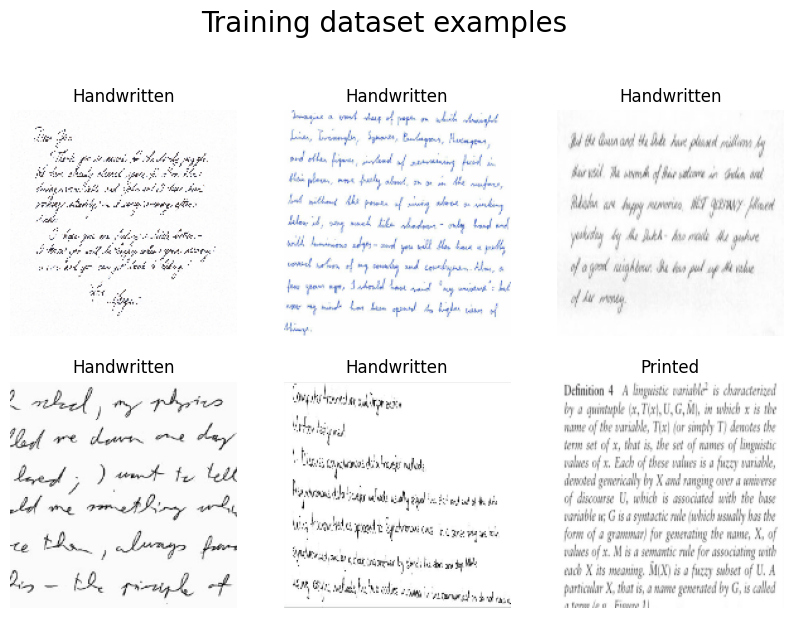

In [108]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.suptitle("Training dataset examples", fontsize=20)
    plt.title(class_names[labels[i]])
    plt.axis("off")

Preprocessed images come in the form 4th rank tensor where first rank is represented by the pixel info at coordinates x, y ∈ {0-180}, and remaining ranks related to RGB 3 channel dimension of an image.

In [109]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(6, 180, 180, 3)
(6,)


Preparing dataset feeding optimization.

In [110]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Due to lack of training data, it is good idea to add data augmentation layer to perform zoomimg and translation of input picture  tensors.

In [111]:
data_augmentation = tf.keras.Sequential([
  # layers.RandomFlip("horizontal"),  # not in use
  # layers.RandomRotation(0.2),    # not in use
  tf.keras.layers.RandomZoom(    # random image zoom
    height_factor=0.25,
    width_factor=0.15,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)  # random image translation
])

#### Building the convolutional neural network.
We use re-scaling layer at the early beginning to have all pixel values in the range 0 to 1 for a better gradient descent.
It is followed by the data augmentation layer earlier defined. The feature extraction is performed by Conv2D layers with ReLu activation functions followed by Max pooling layers. Final layers are dense layers that provide classification weights to a probability model that will be defined later.

In [112]:
num_classes = len(class_names)
from keras.regularizers import l2
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer ='he_normal'),
  tf.keras.layers.MaxPooling2D(),
   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01),      
              bias_regularizer=l2(0.01)),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01),      
              bias_regularizer=l2(0.01)),
   
  tf.keras.layers.Dense(num_classes)
])

Compiling model with optimizer and loss function.

In [113]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-6)

model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build((None, 180, 180, 3))

Let's review CNN model structure.

In [114]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_14 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 89, 89, 32)        9248      
                                                     

It is wise to define early stopping and checkpoint callbacks that will be used during training.

In [115]:
model_file = os.path.join(os.getcwd(), 'best_weights')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 30, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="accuracy", mode="max", 
                    save_best_only=True, verbose=1)

#### Training the model.
Feeding both training and validation datasets to run for a 200 epochs.

In [116]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[checkpoint]
)

Epoch 1/200
6/7 [========================>.....] - ETA: 0s - loss: 3.0026 - accuracy: 0.6389
Epoch 1: accuracy improved from -inf to 0.62162, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 5s 565ms/step - loss: 3.0287 - accuracy: 0.6216 - val_loss: 1.1707 - val_accuracy: 0.6316
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 1.3276 - accuracy: 0.4324
Epoch 2: accuracy did not improve from 0.62162
7/7 [==============================] - 0s 42ms/step - loss: 1.3276 - accuracy: 0.4324 - val_loss: 1.2249 - val_accuracy: 0.3684
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 1.2121 - accuracy: 0.5405
Epoch 3: accuracy did not improve from 0.62162
7/7 [==============================] - 0s 42ms/step - loss: 1.2121 - accuracy: 0.5405 - val_loss: 1.1889 - val_accuracy: 0.3684
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.5405
Epoch 4: accuracy did not improve from 0.62162
7/7 [==============================] - 0s 44ms/step - loss: 1.1672 - accuracy: 0.5405 - val_loss: 1.1637 - val_accuracy: 0.3684
Epoch 5/200
7/7 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 512ms/step - loss: 0.7074 - accuracy: 0.6757 - val_loss: 1.3756 - val_accuracy: 0.4211
Epoch 68/200
7/7 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.5946
Epoch 68: accuracy did not improve from 0.67568
7/7 [==============================] - 0s 43ms/step - loss: 0.7048 - accuracy: 0.5946 - val_loss: 1.4685 - val_accuracy: 0.4211
Epoch 69/200
7/7 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7297
Epoch 69: accuracy improved from 0.67568 to 0.72973, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 534ms/step - loss: 0.7126 - accuracy: 0.7297 - val_loss: 1.1140 - val_accuracy: 0.5263
Epoch 70/200
7/7 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.5946
Epoch 70: accuracy did not improve from 0.72973
7/7 [==============================] - 0s 45ms/step - loss: 0.7096 - accuracy: 0.5946 - val_loss: 1.8507 - val_accuracy: 0.4211
Epoch 71/200
7/7 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.7297
Epoch 71: accuracy did not improve from 0.72973
7/7 [==============================] - 0s 46ms/step - loss: 0.6345 - accuracy: 0.7297 - val_loss: 1.8665 - val_accuracy: 0.5263
Epoch 72/200
7/7 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.5405
Epoch 72: accuracy did not improve from 0.72973
7/7 [==============================] - 0s 42ms/step - loss: 0.9290 - accuracy: 0.5405 - val_loss: 2.1886 - val_accuracy: 0.4211
Epoch 73/200
7/7 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 4s 584ms/step - loss: 0.7246 - accuracy: 0.7568 - val_loss: 2.1534 - val_accuracy: 0.4211
Epoch 77/200
7/7 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5676
Epoch 77: accuracy did not improve from 0.75676
7/7 [==============================] - 0s 42ms/step - loss: 0.7115 - accuracy: 0.5676 - val_loss: 1.6980 - val_accuracy: 0.5263
Epoch 78/200
7/7 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.6757
Epoch 78: accuracy did not improve from 0.75676
7/7 [==============================] - 0s 41ms/step - loss: 0.6911 - accuracy: 0.6757 - val_loss: 2.4433 - val_accuracy: 0.4211
Epoch 79/200
7/7 [==============================] - ETA: 0s - loss: 0.7777 - accuracy: 0.7297
Epoch 79: accuracy did not improve from 0.75676
7/7 [==============================] - 0s 43ms/step - loss: 0.7777 - accuracy: 0.7297 - val_loss: 1.1697 - val_accuracy: 0.5263
Epoch 80/200
7/7 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 539ms/step - loss: 0.6032 - accuracy: 0.7838 - val_loss: 4.2357 - val_accuracy: 0.3684
Epoch 89/200
7/7 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7838
Epoch 89: accuracy did not improve from 0.78378
7/7 [==============================] - 0s 51ms/step - loss: 0.7319 - accuracy: 0.7838 - val_loss: 1.1105 - val_accuracy: 0.5789
Epoch 90/200
7/7 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.7568
Epoch 90: accuracy did not improve from 0.78378
7/7 [==============================] - 0s 41ms/step - loss: 0.6163 - accuracy: 0.7568 - val_loss: 2.0420 - val_accuracy: 0.4737
Epoch 91/200
7/7 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6486
Epoch 91: accuracy did not improve from 0.78378
7/7 [==============================] - 0s 41ms/step - loss: 0.6291 - accuracy: 0.6486 - val_loss: 1.9062 - val_accuracy: 0.4737
Epoch 92/200
7/7 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 502ms/step - loss: 0.6161 - accuracy: 0.8108 - val_loss: 1.3740 - val_accuracy: 0.5263
Epoch 95/200
7/7 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.5676
Epoch 95: accuracy did not improve from 0.81081
7/7 [==============================] - 0s 41ms/step - loss: 0.6277 - accuracy: 0.5676 - val_loss: 2.0837 - val_accuracy: 0.4737
Epoch 96/200
7/7 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.7027
Epoch 96: accuracy did not improve from 0.81081
7/7 [==============================] - 0s 40ms/step - loss: 0.6112 - accuracy: 0.7027 - val_loss: 1.2765 - val_accuracy: 0.5789
Epoch 97/200
7/7 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.7838
Epoch 97: accuracy did not improve from 0.81081
7/7 [==============================] - 0s 42ms/step - loss: 0.5860 - accuracy: 0.7838 - val_loss: 2.6903 - val_accuracy: 0.4737
Epoch 98/200
7/7 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 501ms/step - loss: 0.4700 - accuracy: 0.8378 - val_loss: 1.4257 - val_accuracy: 0.5263
Epoch 130/200
5/7 [====================>.........] - ETA: 0s - loss: 0.5548 - accuracy: 0.7667
Epoch 130: accuracy did not improve from 0.83784
7/7 [==============================] - 0s 40ms/step - loss: 0.5189 - accuracy: 0.8108 - val_loss: 0.9627 - val_accuracy: 0.7368
Epoch 131/200
7/7 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.8378
Epoch 131: accuracy did not improve from 0.83784
7/7 [==============================] - 0s 44ms/step - loss: 0.4392 - accuracy: 0.8378 - val_loss: 0.5566 - val_accuracy: 0.7895
Epoch 132/200
7/7 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8649
Epoch 132: accuracy improved from 0.83784 to 0.86486, saving model to C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights
INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 544ms/step - loss: 0.3978 - accuracy: 0.8649 - val_loss: 0.3367 - val_accuracy: 0.8421
Epoch 133/200
7/7 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7838
Epoch 133: accuracy did not improve from 0.86486
7/7 [==============================] - 0s 41ms/step - loss: 0.6298 - accuracy: 0.7838 - val_loss: 1.7016 - val_accuracy: 0.6316
Epoch 134/200
7/7 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.8108
Epoch 134: accuracy did not improve from 0.86486
7/7 [==============================] - 0s 40ms/step - loss: 0.5102 - accuracy: 0.8108 - val_loss: 0.4807 - val_accuracy: 0.7895
Epoch 135/200
7/7 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7838
Epoch 135: accuracy did not improve from 0.86486
7/7 [==============================] - 0s 42ms/step - loss: 0.5188 - accuracy: 0.7838 - val_loss: 0.3357 - val_accuracy: 0.8947
Epoch 136/200
7/7 [==============================] - ET

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 559ms/step - loss: 0.3430 - accuracy: 0.9189 - val_loss: 0.5216 - val_accuracy: 0.7895
Epoch 141/200
7/7 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.7568
Epoch 141: accuracy did not improve from 0.91892
7/7 [==============================] - 0s 41ms/step - loss: 0.5970 - accuracy: 0.7568 - val_loss: 1.0131 - val_accuracy: 0.7895
Epoch 142/200
7/7 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8108
Epoch 142: accuracy did not improve from 0.91892
7/7 [==============================] - 0s 40ms/step - loss: 0.5001 - accuracy: 0.8108 - val_loss: 0.5165 - val_accuracy: 0.8421
Epoch 143/200
7/7 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.7568
Epoch 143: accuracy did not improve from 0.91892
7/7 [==============================] - 0s 42ms/step - loss: 0.5455 - accuracy: 0.7568 - val_loss: 0.2574 - val_accuracy: 0.9474
Epoch 144/200
7/7 [==============================] - ET

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 524ms/step - loss: 0.2898 - accuracy: 0.9730 - val_loss: 0.2434 - val_accuracy: 0.8947
Epoch 152/200
7/7 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.8108
Epoch 152: accuracy did not improve from 0.97297
7/7 [==============================] - 0s 42ms/step - loss: 0.5196 - accuracy: 0.8108 - val_loss: 1.4086 - val_accuracy: 0.7895
Epoch 153/200
7/7 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8649
Epoch 153: accuracy did not improve from 0.97297
7/7 [==============================] - 0s 41ms/step - loss: 0.3211 - accuracy: 0.8649 - val_loss: 0.2038 - val_accuracy: 0.9474
Epoch 154/200
7/7 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8108
Epoch 154: accuracy did not improve from 0.97297
7/7 [==============================] - 0s 43ms/step - loss: 0.4366 - accuracy: 0.8108 - val_loss: 0.9935 - val_accuracy: 0.8421
Epoch 155/200
7/7 [==============================] - ET

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\best_weights\assets


7/7 [==============================] - 3s 520ms/step - loss: 0.1546 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 1.0000
Epoch 192/200
7/7 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9459
Epoch 192: accuracy did not improve from 1.00000
7/7 [==============================] - 0s 42ms/step - loss: 0.1977 - accuracy: 0.9459 - val_loss: 0.0992 - val_accuracy: 1.0000
Epoch 193/200
7/7 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9459
Epoch 193: accuracy did not improve from 1.00000
7/7 [==============================] - 0s 41ms/step - loss: 0.1640 - accuracy: 0.9459 - val_loss: 0.0928 - val_accuracy: 1.0000
Epoch 194/200
7/7 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8919
Epoch 194: accuracy did not improve from 1.00000
7/7 [==============================] - 0s 41ms/step - loss: 0.3362 - accuracy: 0.8919 - val_loss: 0.1069 - val_accuracy: 1.0000
Epoch 195/200
7/7 [==============================] - ET

Now, we restore the best weights that were obtained during training process.

In [117]:
model.load_weights(model_file)

Saving the model.

In [118]:
model.save(os.getcwd())

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\assets


Defining function for plotting training progress log.

In [119]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.plot(history.epoch, history.history['loss'],
               color = colors[n], label = 'Training' + label)
  plt.plot(history.epoch, history.history['val_loss'],
               color = colors[n], label = 'Validation' + label,
               linestyle = "--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [120]:
plt.rcParams['figure.figsize'] = (12, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

As can be seen from below figure, in contrast to training loss, validation loss have had few extremums that allowed to obtain relatively good training weights at respective checkpoints.

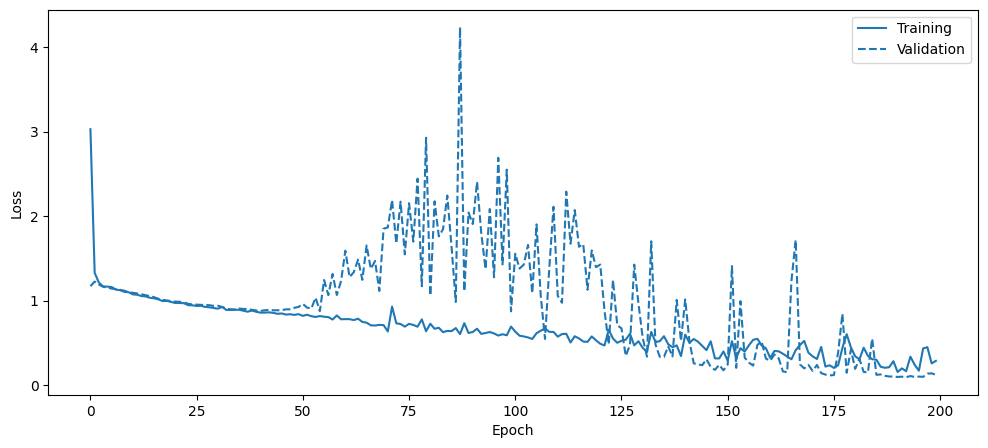

In [121]:
plot_loss(history, '', 0)

#### Model evaluation.

Defining our classification model with softmax activation function, as suggested by the true labels type.

In [122]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

Preparing images to be fed to the classification model.

In [123]:
def get_all_filePaths(folderPath):
    result = []
    for dirpath, dirnames, filenames in os.walk(folderPath):
        result.extend([os.path.join(dirpath, filename) for filename in filenames])
    return result

In [124]:
test_images = []
img_arr = []
for img_path in get_all_filePaths(data_dir):
    img = PIL.Image.open(img_path).convert('RGB')
    img_arr.append(img)
    image = tf.convert_to_tensor(img)
    input_tensor = tf.image.resize(image, [img_height, img_width])
    # add another dimension at the front to get NHWC shape
    test_images.append(tf.expand_dims(input_tensor, axis=0))
len(test_images)

56

Running predictions

In [125]:
predicted = []
for img in test_images:
    predictions = probability_model.predict(img)
    predicted.append(predictions)

1/1 [==============================] - 0s 24ms/step


In [126]:
test_labels = []
test_labels.append(class_names.index('Handwritten'))
test_labels.append(class_names.index('Printed'))

Defining function for plotting images

In [127]:
def plot_image(predictions_array, true_label, img):
  true_label, img = true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

Let us plot few random images with their predicted labels along.

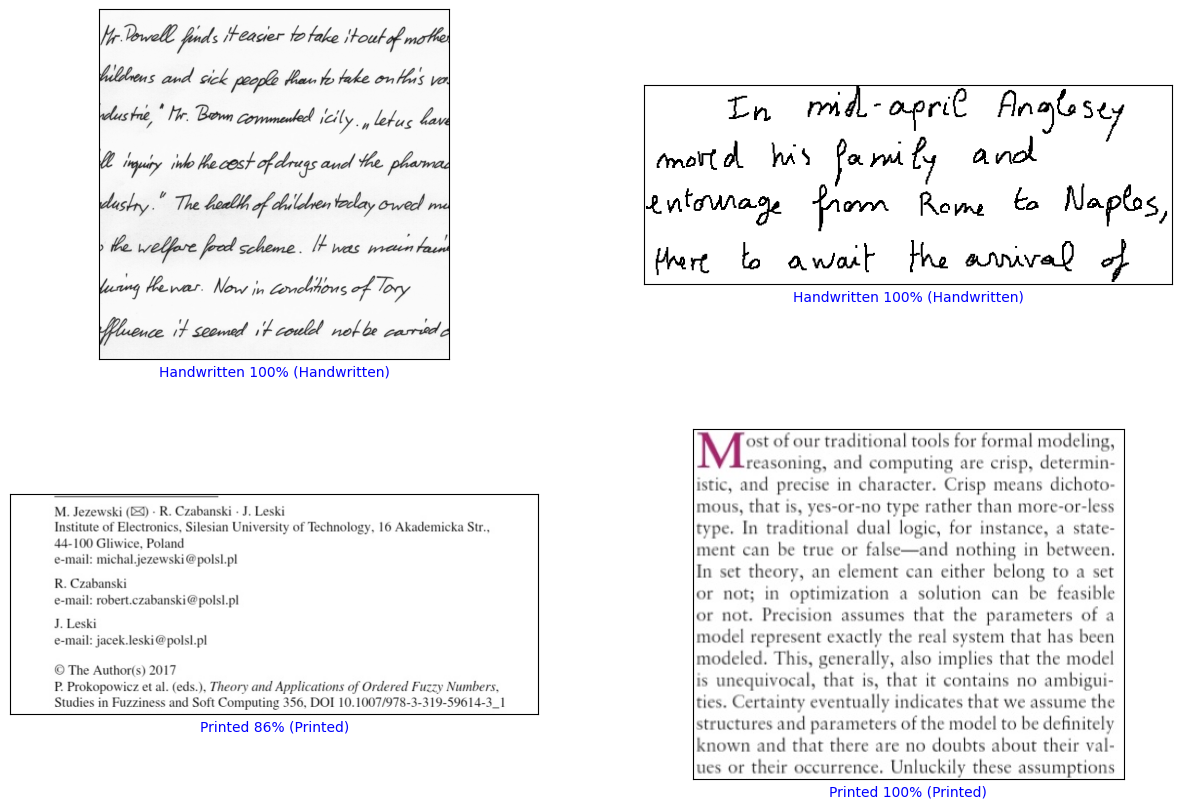

In [128]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_image(predicted[10], test_labels[0], img_arr[10])
plt.subplot(2,2,2)
plot_image(predicted[20], test_labels[0], img_arr[20])
plt.subplot(2,2,3)
plot_image(predicted[30], test_labels[1], img_arr[30])
plt.subplot(2,2,4)
plot_image(predicted[40], test_labels[1], img_arr[40])

plt.show()

Since dataset is very small, we shall evaluate the model over both combined know and unknown to model data.

In [129]:
full_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 2 classes.


As can be seen from obtained result, prediction accuracy is above 70%.

In [130]:
baseline_results = model.evaluate(full_ds,
                                  batch_size=batch_size, verbose=0)
metric_name = []
for i, _ in enumerate(model.metrics):
    metric_name.append(model.metrics[i].name)
metric_results = pd.DataFrame(baseline_results).transpose().round(3)
metric_results.columns = metric_name
metric_results.rename(index={0: 'value'})

,loss,accuracy
value,0.155,0.964


#### Conclusions.
Feature extraction method used in CNN is quite efficient and can provide satisfactory results even with limited training data.
Data augmentation is another useful technique that allows to enrich training dataset with some features using its own content. 